<a href="https://colab.research.google.com/github/orbenishay/Regression-Project/blob/Or/Amsterdam3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amsterdam Airbnb** 

Or Ben-Ishay and Hagai Baumgarten 6/3/2020 Regression project.

https://www.kaggle.com/adityadeshpande23/amsterdam-airbnb

Our Machine_learning study aims to predict prices of Amrsterdam Airbnb apartment according to the various attributes.
The provided dataset includes data of 15K apartments, and 10 features. 


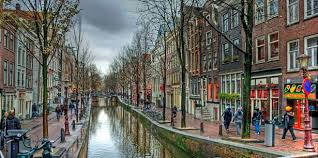


## **Overview:**

**We introduced some noise to the dataset (as it was previously cleaned) in order to demonstrate data cleansing and outlier removal methods**:
*   Outliers (to the overall prices distribution)
*   Outliers (per subset - ex. per number of bedrooms)
*   Bivariate outlier
*   Zero values: in column that shouldn't have zero values
*   Null values

**ML Pipeline**:
*   Feature selection
*   Features Relevance
*   Drop columns with high correlation between them in order not to skew the model
*   Scaling features where required
*   Order categorical data: in case the order of categorical column is known
*   Target transformation in case required (log price etc.)
*   Split dataset to train/test

**EDA:**
*   Histogram: overall distribution of prices
*   Box/Violin plot: distribution of prices by subset (# bedrooms)
*   Pairplot (scatter matrix) between all the numeric columns
*   Correlation heatmap between all the numeric columns
*   Geographical analysis (by latitide/logtitude)
*   Pie: proportion of apartments by various attribues

**Data Cleansing:**
*   Remove entries with zero values (in columns that shouldn't be 0)
*   Remove/replace null values
*   Remove outliers: overall, by subset, bivariate, exponential
*   List item

**Data Manupulation:**
*   Calculate distance from city-center by coordinates
*   Bucket distances to 4 bins
*   Devide locations to North/South, East/West and quartes: NE/NW/SE/SW
*   Convert categorical columns to numeric
*   List item

**Estimators:**

*   KNN
*   Decision trees
*   Linear regression
*   










### **Load Modules:**

In [2]:

import pandas as pd # General tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
from datetime import datetime # Pandas
from datetime import timedelta
from scipy.optimize import curve_fit# For curve fitting
from sklearn.base import TransformerMixin # For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator # For predictions
from sklearn.metrics import mean_squared_log_error as msle # For scoring
from sklearn.metrics import mean_squared_error as mse # For scoring
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
import pydot as pyd # For the tree visualization
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.model_selection import train_test_split # For validation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
!pip install pydot;
# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### **Load dataset:**

In [4]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving Amsterdam3.csv to Amsterdam3.csv


### **Create Dataframe and add categorical columns:**

In [5]:
bnb_orig = pd.read_csv('Amsterdam3.csv', index_col='#')
bnb=bnb_orig

bnb['N_S']=np.where(bnb['latitude']>=52.37854617, 'North', 'South')
bnb['E_W']=np.where(bnb['longitude']>=4.900774603, 'East', 'West')
bnb['Quarter']=bnb['N_S']+"_"+bnb['E_W']

bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,calculated_host_listings_count,guests_included,host_listings_count,minimum_nights,number_of_reviews,instant_bookable,room_type,review_avg,price,ring,N_S,E_W,Quarter
#,,,,,,,,,,,,,,,,,,,
1,52.358466,4.933843,3.279483,4.0,2.0,2.0,1,1,1,2,8,Not Possible,Entire home/apt,55.84,160,Center,South,East,South_East
2,52.363589,4.983353,5.951843,4.0,1.0,2.0,1,2,1,3,0,Not Possible,Entire home/apt,55.34,120,Off Center,South,East,South_East
3,52.375209,4.861647,2.601055,2.0,1.0,1.0,1,1,1,3,8,Not Possible,Entire home/apt,54.48,99,Center,South,West,South_West
4,52.387382,4.890457,1.095138,2.0,1.0,1.0,1,1,1,2,41,Not Possible,Private room,93.38,660,Center,North,West,North_West
5,52.384062,4.889877,0.844491,2.0,1.0,1.0,1,1,1,3,0,Not Possible,Entire home/apt,58.40,175,Center,North,West,North_West


## **Data Cleansing**

In [7]:
bnb.shape # initial size of dataset before all the cleaning steps

(14997, 19)

In [0]:
bnb = bnb[bnb.isnull().sum(axis=1)<1] # Remove rows with more than 1 `NaN`'s.

In [0]:
def drop_zeros(df): # remove zeros with 0 values at either columns
    return df.loc[df.accommodates * df.minimum_nights * df.price != 0]
zeros_dropper = FunctionTransformer(drop_zeros, validate=False)
bnb = zeros_dropper.fit_transform(bnb)

In [0]:
# bnb = bnb.loc[:, ~bnb.columns.str.contains(r'review', case=False)] # remove specific columns

In [0]:
bnb = bnb.loc[:, ~bnb.columns.str.contains(r'calculated', case=False)] # remove specific columns

In [0]:
bnb.drop_duplicates(inplace=True) # Remove duplicates

In [13]:
bnb.drop_duplicates(subset=['latitude', 'longitude'], inplace=True) # Remove duplicates with subsets: Only consider certain columns for identifying duplicates, by default use all of the columns
bnb.index.value_counts().sort_values(ascending=False).head() # look for duplications

2049     1
32       1
8196     1
10245    1
12294    1
Name: #, dtype: int64

In [14]:
bnb.shape # after each cleaning step: check how many rows were deleted 

(14994, 18)


## **Dataset explration**

In [31]:
bnb.nunique() # how many values per field

latitude               14874
longitude              14896
d_centre               14896
accommodates              10
bathrooms                  7
bedrooms                   6
guests_included            7
host_listings_count       32
minimum_nights            27
number_of_reviews        274
instant_bookable           2
room_type                  3
review_avg              1205
price                    318
ring                       4
N_S                        2
E_W                        2
Quarter                    4
dtype: int64

In [27]:
bnb[['room_type','price']].groupby('room_type').describe() # describe with subset

price                         ...                     
                   count        mean        std  ...    50%    75%    max
room_type                                        ...                     
Entire home/apt  11578.0  141.803161  62.724504  ...  125.0  165.0  440.0
Private room      3255.0   86.913978  40.993043  ...   79.0  100.0  400.0
Shared room         63.0   84.301587  54.230284  ...   63.0  109.0  249.0

[3 rows x 8 columns]

In [28]:
bnb.bedrooms.value_counts().head(10) #Count entries per value:

1.0    9192
2.0    3439
3.0    1019
0.0     896
4.0     318
5.0      32
Name: bedrooms, dtype: int64

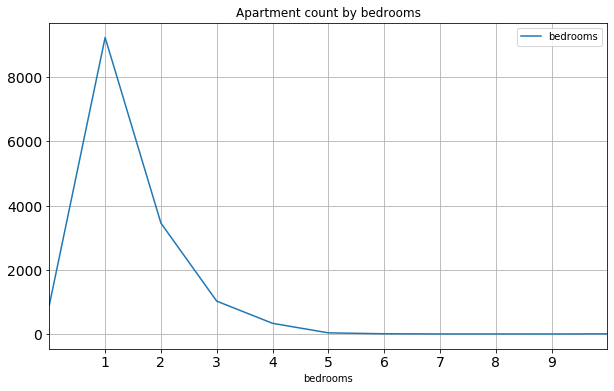

In [15]:
bnb.groupby('bedrooms').agg({'bedrooms':'count'}).plot(figsize=(10,6),title="Apartment count by bedrooms",grid=True,xticks=range(1,10),fontsize=14)
# bnb.groupby('bedrooms').agg({'bedrooms':'count'}).head(10)

In [0]:
bnb = bnb.loc[bnb['bedrooms']<6,:] # filter dataset based on a column's values

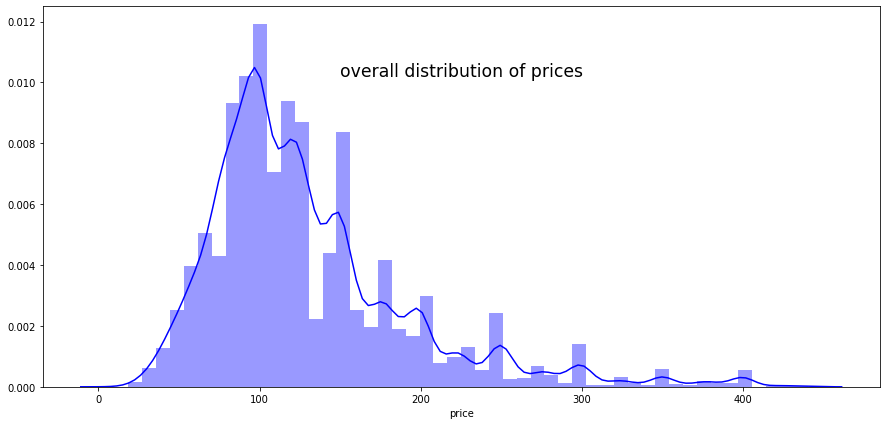

In [19]:
# bnb.hist(column='price', by='instant_bookable', bins=50, sharex=True, sharey=True);
plt.figure(figsize=(15,7))
plt.title('overall distribution of prices', x=0.5, y=0.8, ha='center', fontsize='xx-large')
sns.distplot(bnb.price, bins=50, kde=True,  color='blue');
plt.show()
# bnb[['price']].sort_values('price', ascending=False).head(20)

In [0]:
bnb = bnb.loc[bnb['price']<500,:] # filter dataset based on a column's values

### **6 Sigma Outlier removal (continuous numeric columns)**

In [20]:
for col in [bnb.longitude, bnb.latitude, bnb.d_centre, bnb.price, bnb.minimum_nights, bnb.accommodates, bnb.bathrooms, bnb.guests_included]: # remove outliers >6 sigma from all the fields
        std = col.std()       
        ave = col.mean()
        bnb = bnb.loc[col.between(ave-6*std, ave+6*std)]


bnb.shape

(14896, 18)

### **Outlier removal with subset**

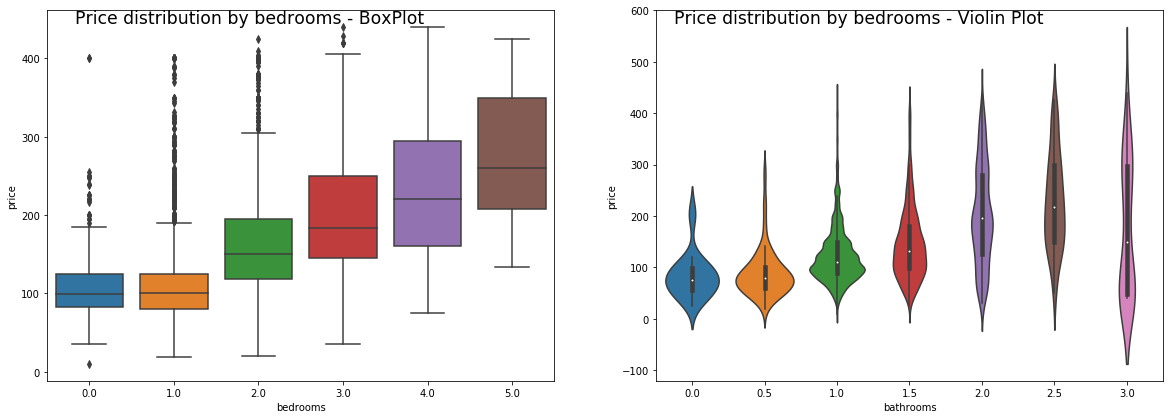

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
fig.set_size_inches(20,15)
sns.boxplot(x='bedrooms', y='price', hue=None, data=bnb, order=None, hue_order=None,ax=ax1);
sns.violinplot(x='bathrooms', y='price', data=bnb,ax=ax2);
ax1.set_title("Price distribution by bedrooms - BoxPlot", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax2.set_title("Price distribution by bedrooms - Violin Plot", x=0.4, y=0.95, ha='center', fontsize='xx-large');


## **Transformation**

In [0]:
# non-numerical data into numerical data - utilize the "order" of the categories
#room_type_order = ['Entire home / apt', 'Private room', 'Shared room']
#room_type_map = dict(zip(room_type_order, range(len(room_type_order))))
#bnb.loc[:, 'room_type_n'] = bnb['room_type'].map(room_type_map) #
#bnb.head()

In [0]:
bnb['bedroom_price_mean']=bnb.groupby('bedrooms')['price'].transform('mean')
bnb['bedroom_price_std']=bnb.groupby('bedrooms')['price'].transform('std')
bnb = bnb.loc[bnb.price<bnb.bedroom_price_mean+bnb.bedroom_price_std*6]

In [0]:
bnb['instant_bookable_boo'] = bnb['instant_bookable'].replace({'Not Possible': 0, 'Possible': 1})
bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,number_of_reviews,instant_bookable,room_type,review_avg,price,ring,N_S,E_W,Quarter,bedroom_price_mean,bedroom_price_std,instant_bookable_boo
#,,,,,,,,,,,,,,,,,,,,,
9768,52.345389,4.817839,6.690642,1.0,0.0,1.0,1,2,1,16,Not Possible,Shared room,0.708962,25,Off Center,South,West,South_West,108.173016,44.397782,0
456,52.362756,4.951517,3.977813,2.0,0.0,1.0,1,1,1,87,Not Possible,Private room,0.768062,75,Off Center,South,East,South_East,108.173016,44.397782,0
2578,52.344844,4.898198,3.817490,2.0,0.0,1.0,1,4,1,8,Not Possible,Private room,0.787619,85,Center,South,West,South_West,108.173016,44.397782,0
3844,52.367105,4.860719,2.949743,2.0,0.0,1.0,1,7,1,3,Not Possible,Private room,0.740230,75,Center,South,West,South_West,108.173016,44.397782,0
4466,52.366334,4.860399,3.008866,2.0,0.0,1.0,1,7,1,2,Not Possible,Private room,0.777273,85,Center,South,West,South_West,108.173016,44.397782,0


In [0]:
# non-numerical data into numerical data - utilize the "order" of the categories
#ring_order = ['Center','Off Center','periphery','Suburbs']
#ring_order_map = dict(zip(ring_order, range(len(ring_order))))
#bnb.loc[:, 'ring_n'] = bnb['ring'].map(ring_order_map) #
#bnb.head()

In [0]:
X = diamonds.drop('price', axis=1, inplace=False)
y = diamonds.price
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=142857) # this splits the dataset randomly but the same way

p_opt, _ = curve_fit(diamond_pricing, X_train, y_train) # apply curve fit

prms = dict(zip(['a', 'b', 'c', 'd'], p_opt))
print(prms)

y_pred = X_train.apply(diamond_pricing, axis=1, **prms)

# Convert categorical fields to numeric:
people_dummies = pd.get_dummies(people, drop_first=True)

## **EDA**

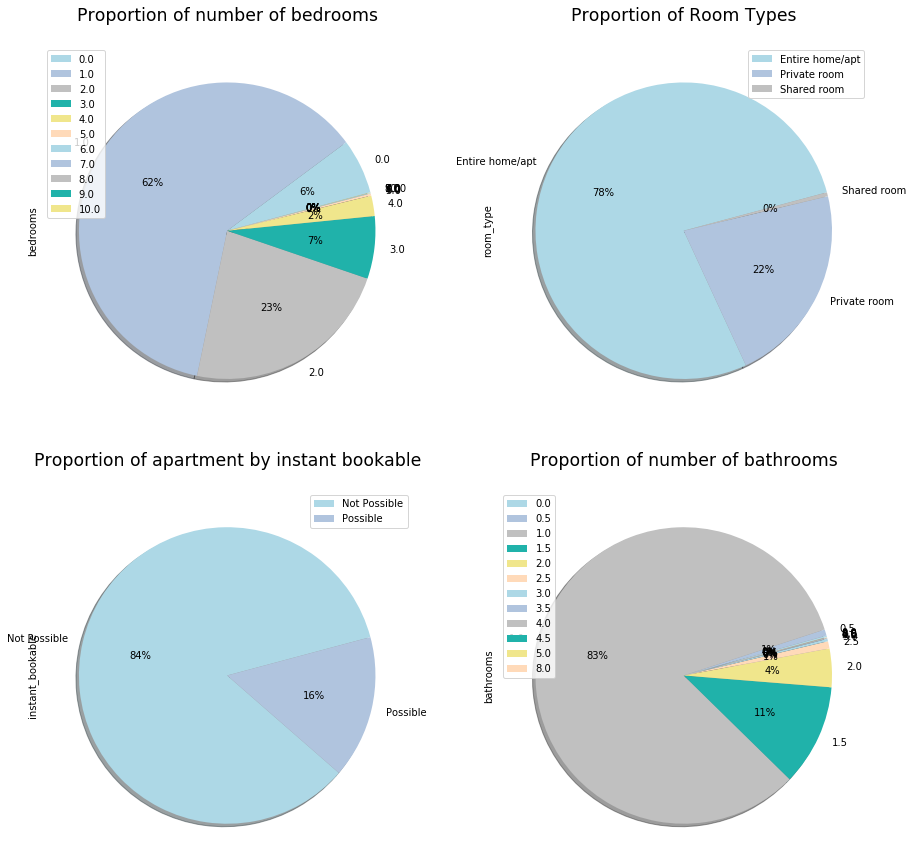

In [121]:
my_colors = ['lightblue','lightsteelblue','silver','lightseagreen','khaki','peachpuff']
fig = plt.figure()
fig.set_size_inches(15,15)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

bnb.groupby('bedrooms').agg({'bedrooms':'count'}).plot.pie(y='bedrooms',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax1)
bnb.groupby('room_type').agg({'room_type':'count'}).plot.pie(y='room_type',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True, ax=ax2)
bnb.groupby('instant_bookable').agg({'instant_bookable':'count'}).plot.pie(y='instant_bookable',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True,ax=ax3)
bnb.groupby('bathrooms').agg({'bathrooms':'count'}).plot.pie(y='bathrooms',autopct='%1.f%%', startangle=15,colors=my_colors,shadow = True,ax=ax4)

ax1.set_title('Proportion of number of bedrooms', x=0.5, y=1.05, ha='center', fontsize='xx-large');
ax2.set_title('Proportion of Room Types', x=0.5, y=1.05, ha='center', fontsize='xx-large');
ax3.set_title('Proportion of apartment by instant bookable', x=0.5, y=1.05, ha='center', fontsize='xx-large');
ax4.set_title('Proportion of number of bathrooms', x=0.5, y=1.05, ha='center', fontsize='xx-large');


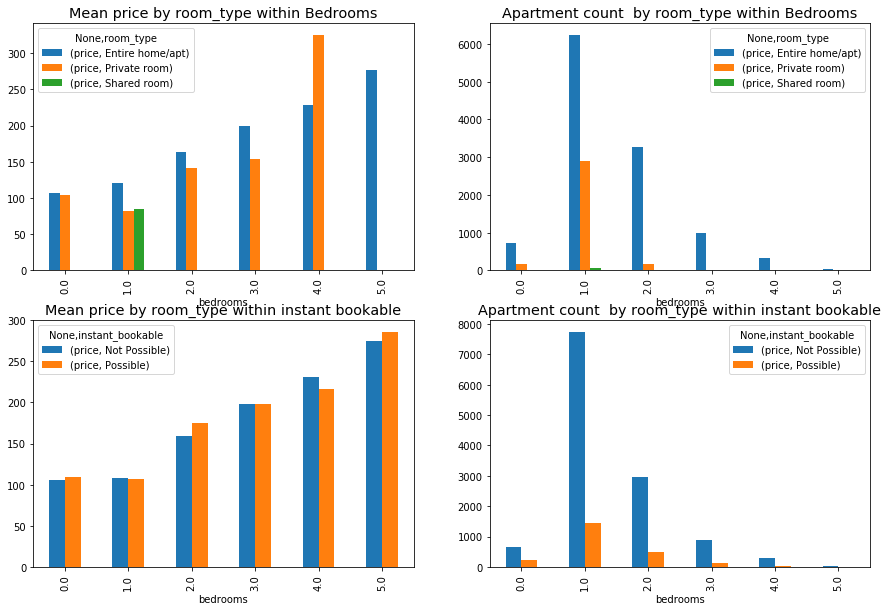

In [44]:
fig = plt.figure()
fig.set_size_inches(15,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

bnb.groupby(['bedrooms','room_type']).agg({'price': 'mean'}).unstack(-1).plot(kind='bar', ax=ax1);
bnb.groupby(['bedrooms','room_type']).agg({'price': 'count'}).unstack(-1).plot(kind='bar', ax=ax2);
bnb.groupby(['bedrooms','instant_bookable']).agg({'price': 'mean'}).unstack(-1).plot(kind='bar', ax=ax3);
bnb.groupby(['bedrooms','instant_bookable']).agg({'price': 'count'}).unstack(-1).plot(kind='bar', ax=ax4);

ax1.set_title('Mean price by room_type within Bedrooms', x=0.5, y=1.0, ha='center', fontsize='x-large');
ax2.set_title('Apartment count  by room_type within Bedrooms', x=0.5, y=1.0, ha='center', fontsize='x-large');
ax3.set_title('Mean price by room_type within instant bookable', x=0.5, y=1.0, ha='center', fontsize='x-large');
ax4.set_title('Apartment count  by room_type within instant bookable', x=0.5, y=1.0, ha='center', fontsize='x-large');


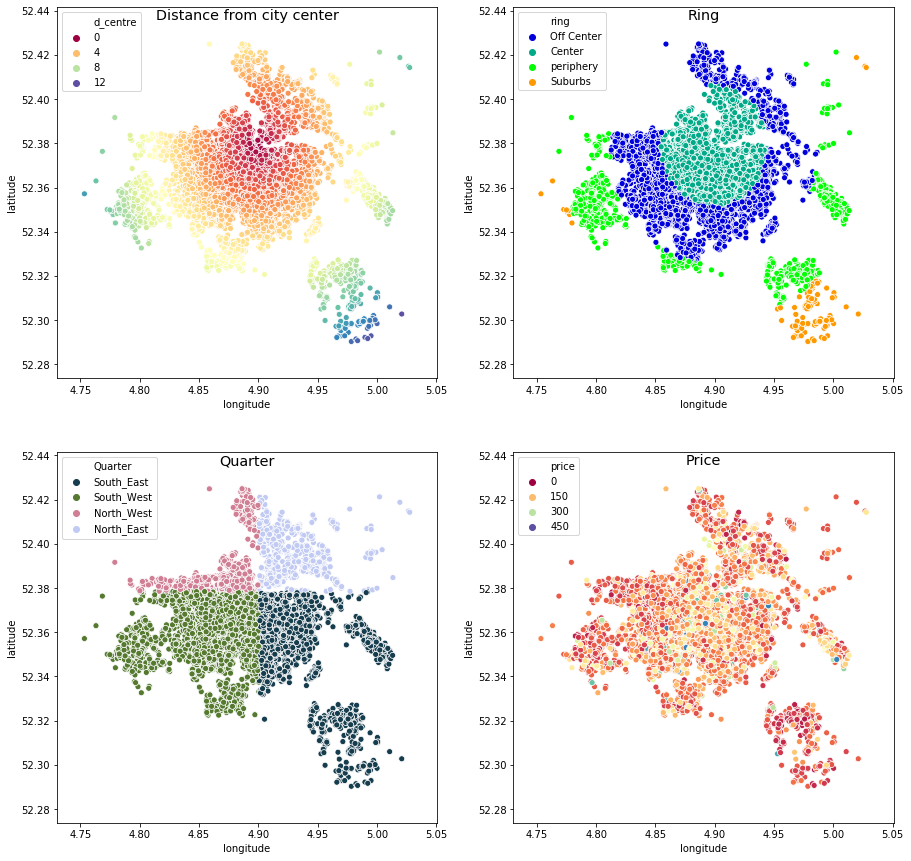

In [73]:
bnb['ring']=pd.cut(x=bnb['d_centre'], bins=4, right=True, labels=['Center','Off Center','periphery','Suburbs'],\
retbins=False, precision=3, include_lowest=False, duplicates='raise') # bin distance  

fig = plt.figure()
fig.set_size_inches(15,15)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
# bnb.plot(kind = 'scatter',x='longitude',y='latitude', c='d_centre',colormap='viridis', ax=ax1)
sns.scatterplot(x='longitude', y='latitude', hue='d_centre', data=bnb, palette="Spectral", ax=ax1);
sns.scatterplot(x='longitude', y='latitude', hue='ring', data=bnb, palette="nipy_spectral", ax=ax2); # husl, cubehelix
sns.scatterplot(x='longitude', y='latitude', hue='Quarter', data=bnb, palette="cubehelix", ax=ax3);
sns.scatterplot(x='longitude', y='latitude', hue='price', data=bnb, palette="Spectral", ax=ax4);
ax1.set_title('Distance from city center', x=0.5, y=0.95, ha='center', fontsize='x-large');
ax2.set_title('Ring', x=0.5, y=0.95, ha='center', fontsize='x-large');
ax3.set_title('Quarter', x=0.5, y=0.95, ha='center', fontsize='x-large');
ax4.set_title('Price', x=0.5, y=0.95, ha='center', fontsize='x-large');

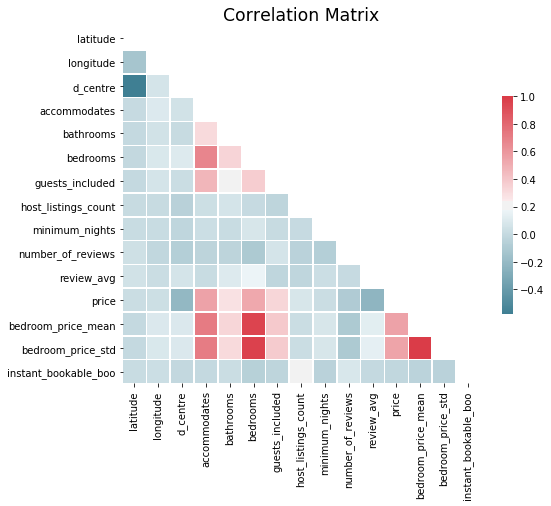

In [0]:
# Correlation matrix:
corr = bnb.corr()
mask = np.zeros_like(corr, dtype=np.bool) #Generating a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8,8)) #Setting up the matplotlib figure
cmap = sns.diverging_palette(220,10, as_cmap=True) #Generating a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax) #Drawing the heatmap with the mask
plt.title("Correlation Matrix", fontsize='xx-large')
plt.show()

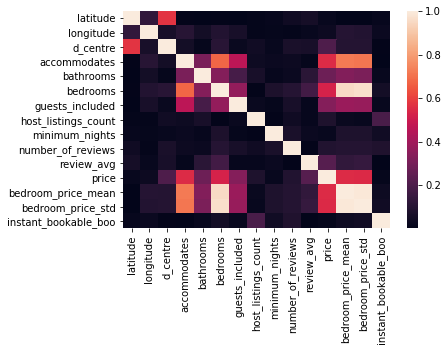

In [0]:
sns.heatmap(bnb.corr().abs())

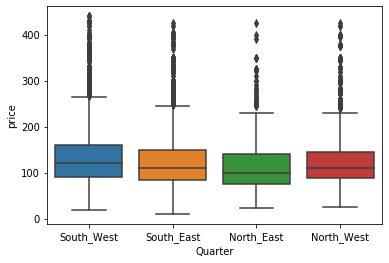

In [0]:
sns.boxplot(x='Quarter', y='price', hue=None, data=bnb, order=None, hue_order=None);

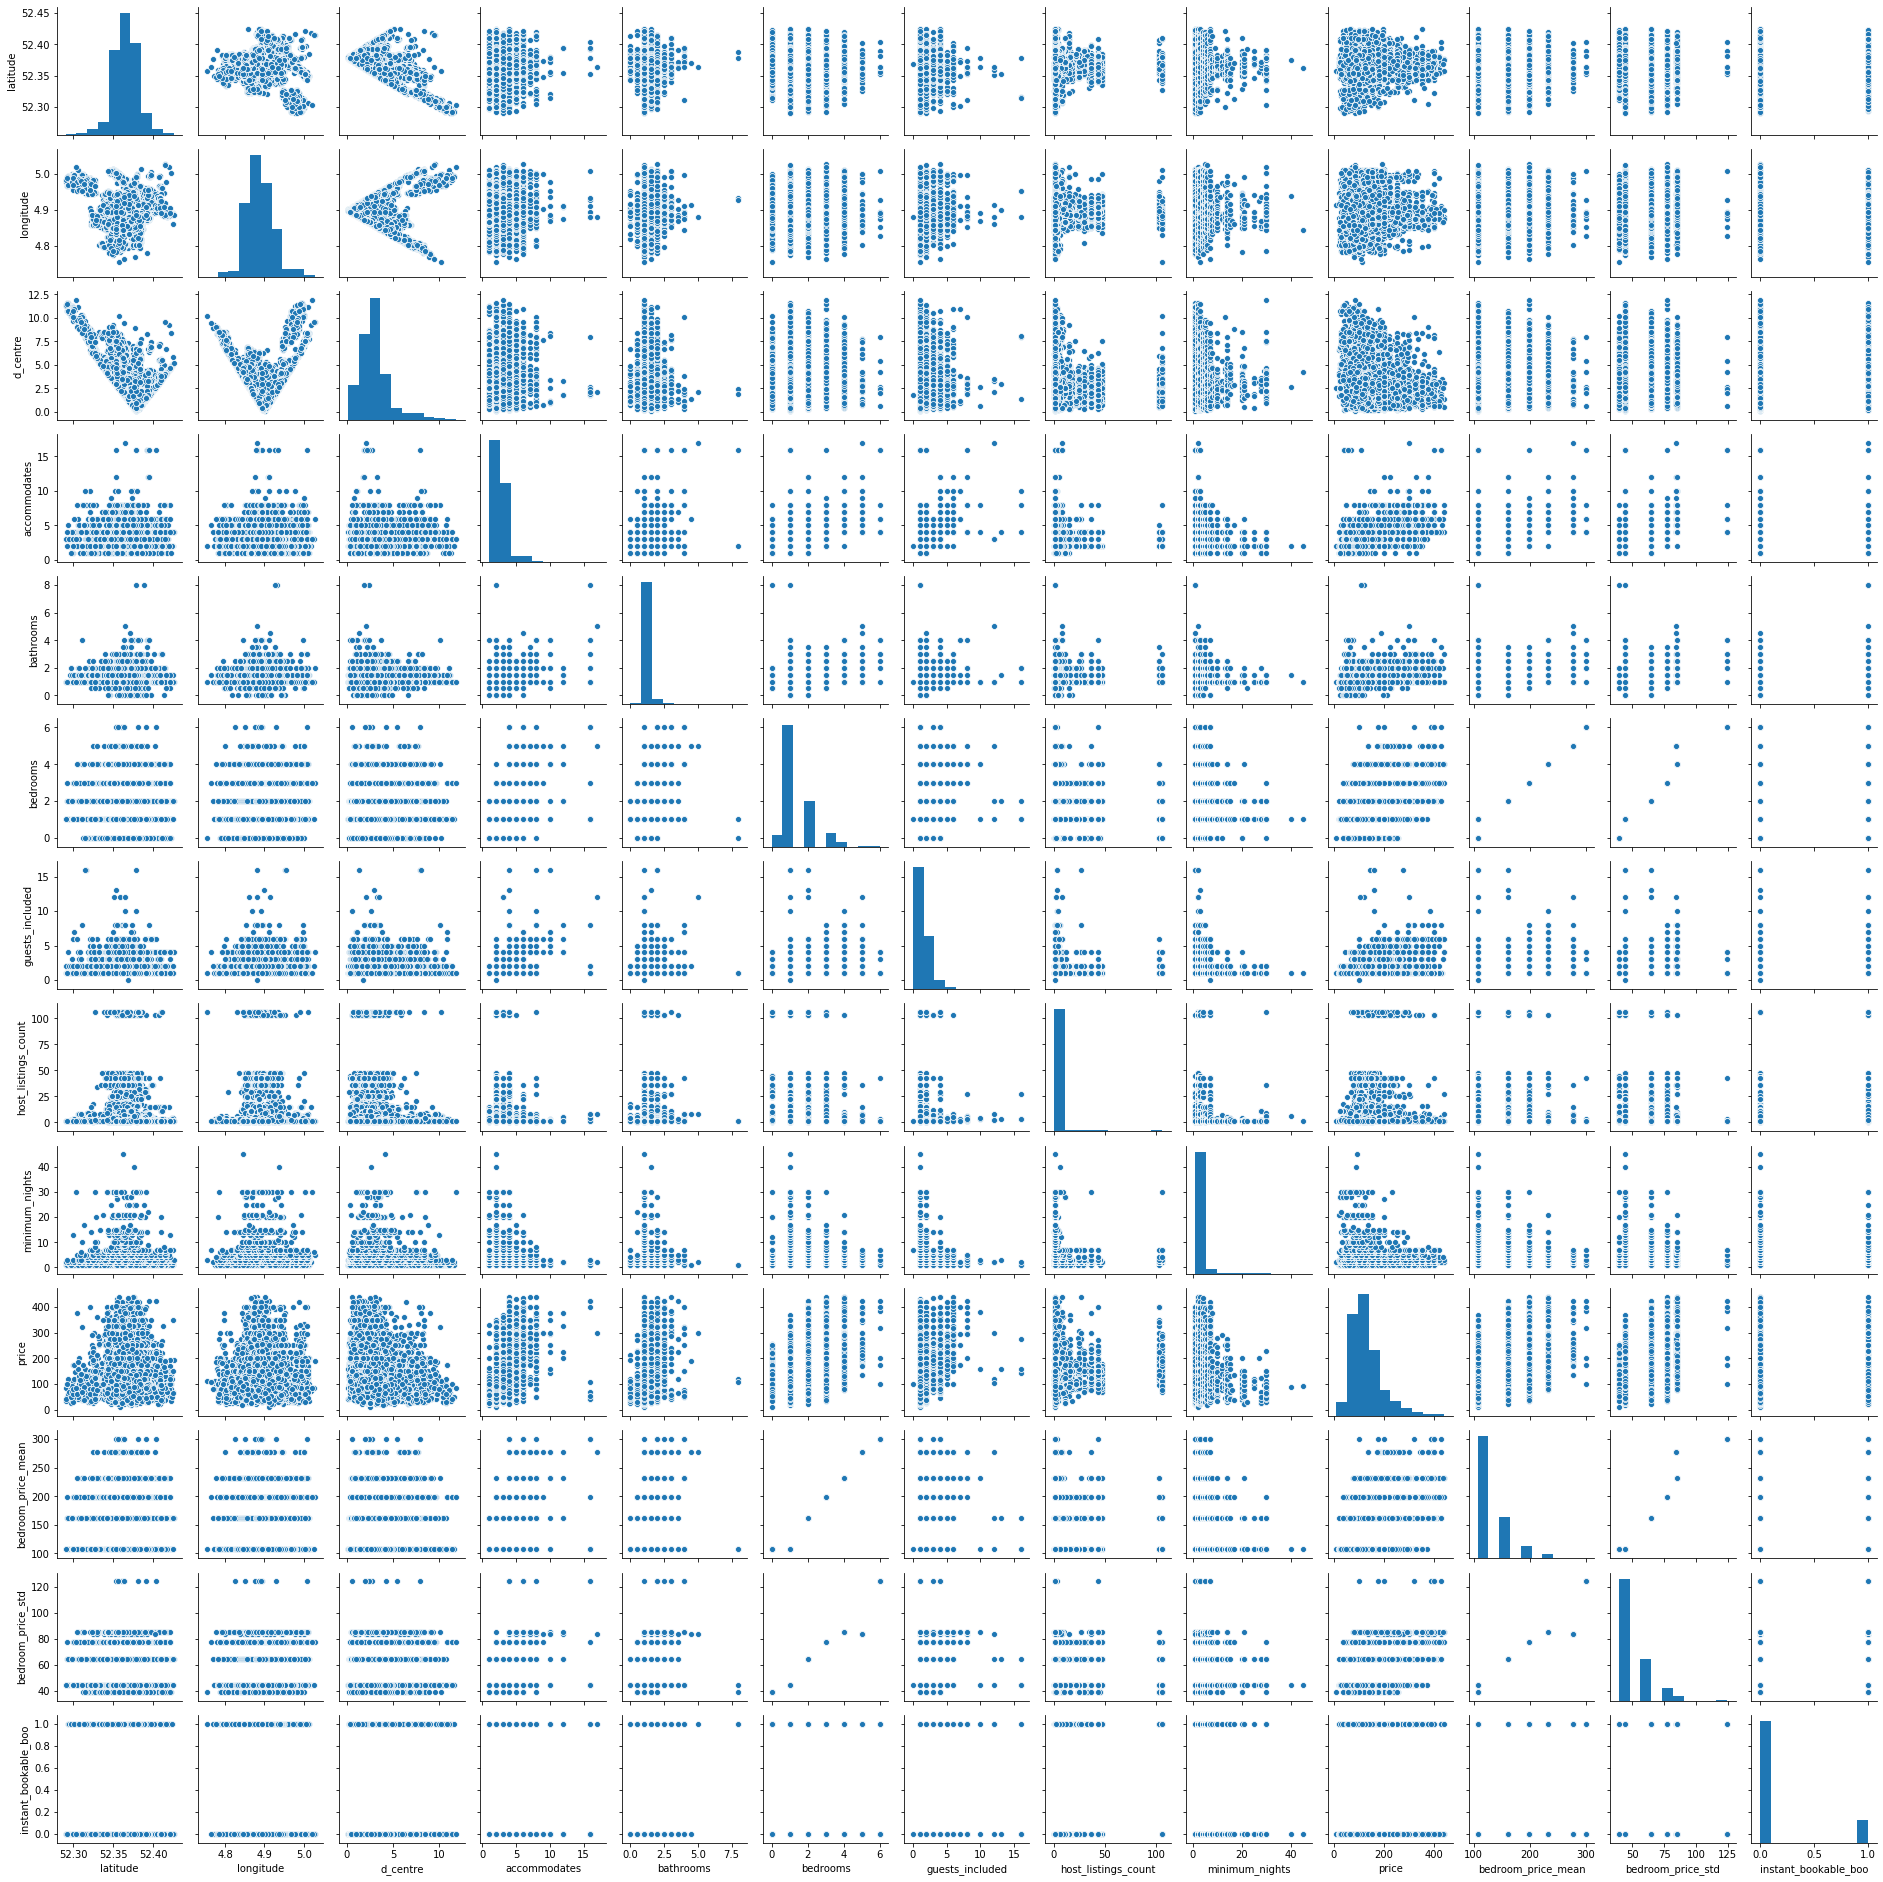

In [0]:
bnb_num = bnb.select_dtypes(include=np.number)
sns.pairplot(bnb_num, height=2)

## **Splitting the data**

In [0]:
bnb_num = bnb.select_dtypes(include=np.number)

In [0]:
X = bnb_num.drop('price', axis=1, inplace=False)
y = bnb_num.price
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=142857) # this splits the dataset randomly but the same way

## Scoring

In [0]:
def rmsle(y_true, y_pred): # function for scoring the model
    return (((np.log1p(y_true)-np.log1p(y_pred))**2).mean())**0.5

# **Models**

## Decision tree

In [0]:
bnb_model = DecisionTreeRegressor(min_samples_split=50, min_impurity_split=0.001)
bnb_model.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=0.001,
                      min_samples_leaf=1, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pyd.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=1200) 

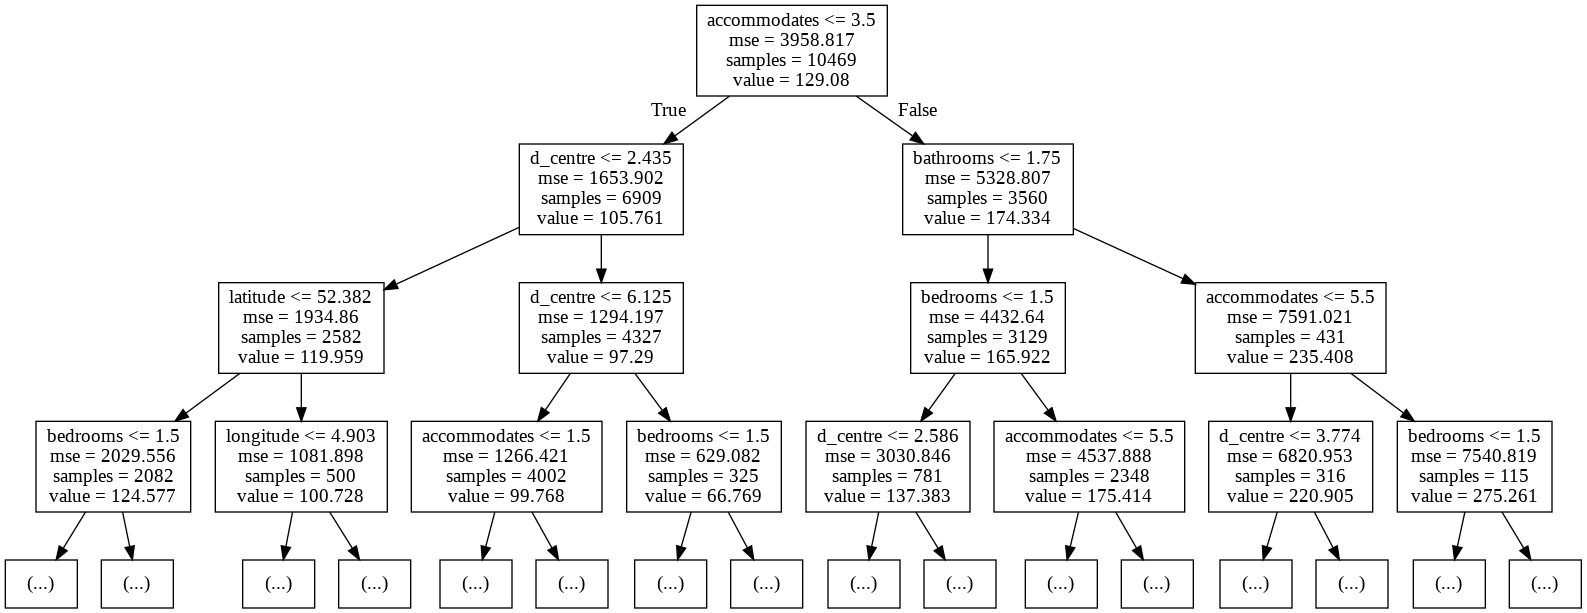

In [0]:
visualize_tree(bnb_model, 3)

In [0]:
for feature, importance in zip(X.columns, bnb_model.feature_importances_):
    print('{:12}: {}'.format(feature, importance))

latitude    : 0.04463855737687475
longitude   : 0.0472401267685441
d_centre    : 0.1036904464819486
accommodates: 0.43264081255196707
bathrooms   : 0.06616568443362619
bedrooms    : 0.008043592108428792
guests_included: 0.02356123913009406
host_listings_count: 0.011199887550860592
minimum_nights: 0.009377038199728197
number_of_reviews: 0.023735732017886334
review_avg  : 0.14430773577460282
bedroom_price_mean: 0.027870019713080518
bedroom_price_std: 0.056521039680246174
instant_bookable_boo: 0.0010080882121117874


In [0]:
y_train_pred = bnb_model.predict(X_train)

In [0]:
X_train.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,number_of_reviews,review_avg,bedroom_price_mean,bedroom_price_std,instant_bookable_boo
#,,,,,,,,,,,,,,
4354,52.362297,4.904921,1.913748,2.0,1.0,2.0,2,1,5,6,0.845036,161.959652,64.673345,0
13398,52.380009,4.883383,1.092413,4.0,1.0,2.0,2,43,2,19,0.828632,161.959652,64.673345,0
11726,52.384410,4.877927,1.569778,2.0,1.0,1.0,1,1,3,9,0.718052,108.173016,44.397782,0
9770,52.368787,4.918005,1.709974,4.0,1.0,3.0,1,1,3,6,0.797152,198.547945,77.416241,0
7304,52.361073,4.851093,3.848189,2.0,1.0,1.0,1,1,3,9,0.777085,108.173016,44.397782,1


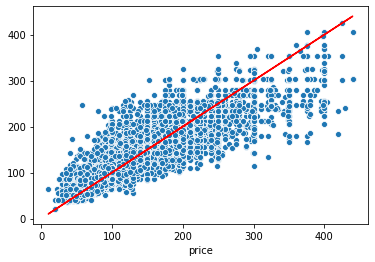

In [0]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [0]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

34.37134880317869

In [0]:
y_test_pred = bnb_model.predict(X_test)

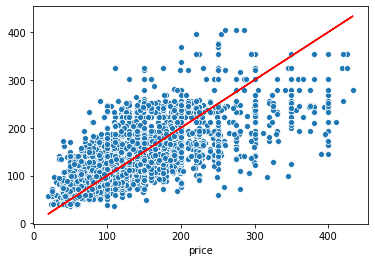

In [0]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [0]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

46.28269222795783

In [0]:
bnb_new = pd.DataFrame({   'latitude': [52.36710497, 52.26710497, 52.16710497],
                           'longitude': [4.8512670343, 4.97240343, 4.912340343], 
                           'd_centre': [1.0773496, 2.0773496, 3.0773496], 
                           'accommodates': [2, 1, 4], 
                           'bathrooms': [1, 0.5, 1],
                           'bedrooms': [1,0,2,],
                           'guests_included' : [2,1,4],
                           'host_listings_count' : [1,1,1],
                            'minimum_nights' : [1,1,2],
                           'instant_bookable_boo' : [0,0,0]
                                                         })
bnb_new.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,instant_bookable_boo
0,52.367105,4.851267,1.07735,2,1.0,1,2,1,1,0
1,52.267105,4.972403,2.07735,1,0.5,0,1,1,1,0
2,52.167105,4.912340,3.07735,4,1.0,2,4,1,2,0


In [0]:
bnb_new = bnb_new[X.columns]

In [0]:
bnb_model.predict(bnb_new) # predict for new data points 

array([197.8       ,  83.33333333, 151.83333333])

In [0]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

57.18709657841593

## KNN

In [0]:
bnb_model_knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

In [0]:
y_train_pred = bnb_model_knn.predict(X_train)

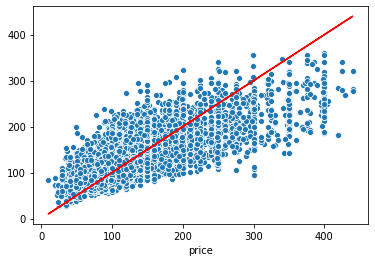

In [0]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [0]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

40.1006246772103

In [0]:
y_test_pred = bnb_model_knn.predict(X_test)

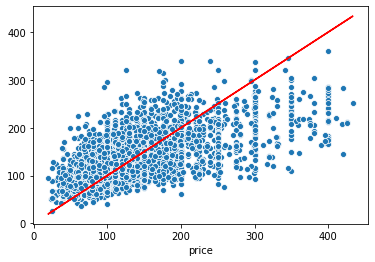

In [0]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [0]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.0

In [0]:
bnb_new_2 = pd.DataFrame({   'latitude': [52.36710497, 52.26710497, 52.16710497],
                           'longitude': [4.8512670343, 4.97240343, 4.912340343], 
                           'd_centre': [1.0773496, 2.0773496, 3.0773496], 
                           'accommodates': [2, 1, 4], 
                           'bathrooms': [1, 0.5, 1],
                           'bedrooms': [1,0,2,],
                           'guests_included' : [2,1,4],
                           'host_listings_count' : [1,1,1],
                            'minimum_nights' : [1,1,2],
                           'instant_bookable_boo' : [0,0,0]
                                                         })
bnb_new_2.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,instant_bookable_boo
0,52.367105,4.851267,1.07735,2,1.0,1,2,1,1,0
1,52.267105,4.972403,2.07735,1,0.5,0,1,1,1,0
2,52.167105,4.912340,3.07735,4,1.0,2,4,1,2,0


In [0]:
bnb_new_2 = bnb_new_2[X.columns]

In [0]:
bnb_model_knn.predict(bnb_new_2) # predict for new data points 

## Regression Model

In [0]:
bnb_lin = LinearRegression().fit(X_train, y_train)

In [0]:
list(zip(X_train.columns, bnb_lin.coef_))

[('latitude', -758.1519712453018),
 ('longitude', -62.87128864180096),
 ('d_centre', -14.063086020072646),
 ('accommodates', 16.20750233057023),
 ('bathrooms', 13.442486652850828),
 ('bedrooms', 22.174464208993598),
 ('guests_included', 5.675340624394403),
 ('host_listings_count', 0.44015469524519624),
 ('minimum_nights', -0.47796125075193263)]

In [0]:
y_train_pred = bnb_lin.predict(X_train)

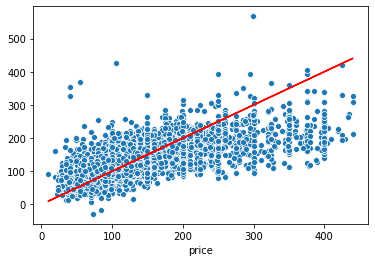

In [0]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [0]:
mse(y_train, y_train_pred)**0.5

47.34106670236043

In [0]:
y_test_pred = bnb_lin.predict(X_test)

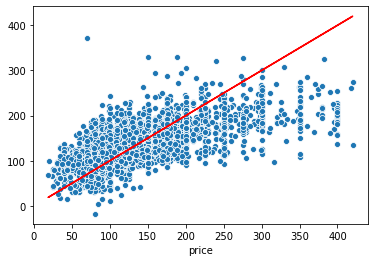

In [0]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [0]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

46.86524335545657

In [0]:
X_train.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,instant_bookable_boo
#,,,,,,,,,,
207,52.410793,4.961214,5.466775,4.0,1.0,2.0,2,1,3,0
3898,52.414879,5.026701,9.497504,3.0,1.0,1.0,2,1,6,0
14056,52.380360,4.855818,2.961253,3.0,1.0,1.0,4,1,3,0
2101,52.348262,5.007992,8.128987,7.0,3.0,4.0,1,1,3,0
8799,52.373560,4.899381,0.625504,6.0,1.0,3.0,1,8,3,0


In [0]:
bnb_new_3 = pd.DataFrame({  'latitude': [52.36710497, 52.26710497, 52.16710497],
                           'longitude': [4.8512670343, 4.97240343, 4.912340343], 
                           'd_centre': [1.0773496, 2.0773496, 3.0773496], 
                           'accommodates': [2, 1, 4], 
                           'bathrooms': [1, 0.5, 1],
                           'bedrooms': [1,0,2,],
                           'guests_included' : [2,1,4],
                           'host_listings_count' : [1,1,1],
                            'minimum_nights' : [1,1,2],
                           'instant_bookable_boo' : [0,0,0]
                                                         })
bnb_new_3.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,guests_included,host_listings_count,minimum_nights,instant_bookable_boo
0,52.367105,4.851267,1.07735,2,1.0,1,2,1,1,0
1,52.267105,4.972403,2.07735,1,0.5,0,1,1,1,0
2,52.167105,4.912340,3.07735,4,1.0,2,4,1,2,0


In [0]:
bnb_lin.predict(bnb_new_3) # predict for new data points 

ValueError: ignored